In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, Conv2DTranspose, LeakyReLU
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras import Sequential

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("../wann/methods")

from DANN import DANN
from ADDA import ADDA
from MCD import MCD
from MDD import MDD
from WANN import WANN
from BalancedWeighting import BalancedWeighting

from warnings import filterwarnings
filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
def concat_files(domains):   
    for domain in domains:
        path = "../dataset/citycam/%s"%domain
        for r, d, f in os.walk(path):
            for direct in d:
                if "checkpoints" not in direct:
                    x_path = path + "/" + direct + "/" + "X.npy"
                    y_path = path + "/" + direct + "/" + "y.npy"

                    Xi = np.load(x_path)
                    yi = np.load(y_path)

                    try:
                        X = np.concatenate((X, Xi))
                        y = np.concatenate((y, yi))
                    except:
                        X = np.copy(Xi)
                        y = np.copy(yi)
    return X, y

In [7]:
source = ["253", "511", "572"]
target = ["495"]
n_target_labeled = 50

Xs, ys = concat_files(source)
Xt, yt = concat_files(target)

X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, yt))

src_index = np.array(range(len(ys)))
tgt_index = np.array(range(len(ys), len(ys) + len(yt)))

np.random.seed(0)
tgt_index_labeled = np.random.choice(tgt_index, n_target_labeled, replace=False)

train_index = np.concatenate((src_index, tgt_index_labeled))

std_sc = StandardScaler()
std_sc.fit(X[src_index])

X = std_sc.transform(X)

mu = ys.mean()
std = ys.std()

y = (y - mu) / std

In [8]:
def get_base_model(shape, activation=None, C=1., name="BaseModel"):
    inputs = Input(shape=(shape,))
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dense(100, activation='relu',
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(1, activation=activation,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled, name=name)
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    return model


def get_encoder(shape, C=1, name="encoder"):
    inputs = Input(shape=(shape,))
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dense(100, activation='relu',
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model


def get_task(shape, C=1, activation=None, name="task"):
    inputs = Input(shape=(shape,))
    modeled = Dense(1, activation=activation,
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    model = Model(inputs, modeled)
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model


fit_params = dict(epochs=200,
                  batch_size=1000,
                  verbose=0)

In [13]:
np.random.seed(0)
seeds = np.random.choice(2**16, 10)

epochs = 100
batch_size = 1000

scores = {}

for i in range(10):
    for method in ["DANN", "ADDA", "MCD", "MDD", "WANN", "BalancedWeighting", "TgtOnly", "SrcOnly", "NoReweight"]:
        print(method)
        if not method in scores:
            scores[method] = []
        
        if method in ["TgtOnly", "SrcOnly", "NoReweight"]:
            np.random.seed(seeds[i])
            tf.random.set_seed(seeds[i])
            
            model = get_base_model(shape=X.shape[1])
        
            if method == "TgtOnly":
                model.fit(X[tgt_index_labeled], y[tgt_index_labeled], epochs=epochs, batch_size=batch_size, verbose=0)
            if method == "SrcOnly":
                model.fit(X[src_index], y[src_index], epochs=epochs, batch_size=batch_size, verbose=0)
            if method == "NoReweight":
                model.fit(X[train_index], y[train_index], epochs=epochs, batch_size=batch_size, verbose=0)
        
        elif method in ["WANN", "BalancedWeighting"]:
            np.random.seed(seeds[i])
            tf.random.set_seed(seeds[i])
            
            if method == "WANN":
                model = WANN(get_base_model=get_base_model, C=1., optimizer=Adam(0.001))
            if method == "BalancedWeighting":
                balanced = BalancedWeighting(get_base_model, C=1., optimizer=Adam(0.001))
                
            model.fit(X, y, [src_index, tgt_index_labeled], epochs=epochs, verbose=0, batch_size=batch_size)
        
        else:
            np.random.seed(seeds[i])
            tf.random.set_seed(seeds[i])
            
            if method == "DANN":
                model = DANN(get_encoder=get_encoder, get_task=get_task, optimizer=Adam(0.001), lambda_=0.01)
            if method == "MCD":
                model = MCD(get_encoder=get_encoder, get_task=get_task, optimizer=Adam(0.001), lambda_=0.1)
            if method == "MDD":
                model = MDD(get_encoder=get_encoder, get_task=get_task, optimizer=Adam(0.001), lambda_=0.1)
            if method == "ADDA":
                model = ADDA(get_encoder=get_encoder, get_task=get_task, get_discriminer=get_task, optimizer=Adam(0.00001), optimizer_task=Adam(0.001))

            model.fit(X, y, [src_index, tgt_index, tgt_index_labeled], epochs=epochs, batch_size=batch_size, verbose=0)

        err_s = np.mean(np.abs(model.predict(X).ravel()[src_index] - y[src_index]) * std)
        err_t = np.mean(np.abs(model.predict(X).ravel()[tgt_index] - y[tgt_index]) * std)

        scores[method].append(err_t)

        print("source %.3f"%err_s)
        print("target %.3f"%err_t)

source 0.621
target 2.406


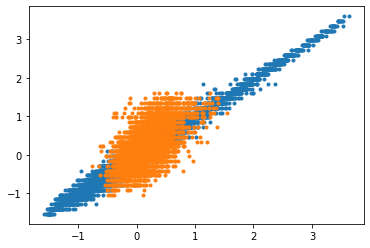

In [19]:
np.random.seed(seeds[6])
tf.random.set_seed(seeds[6])

wann = WANN(get_base_model, C=1., optimizer=Adam(0.001))

wann.fit(X, y, [src_index, tgt_index_labeled], epochs=100, verbose=0, batch_size=1000)

plt.plot(wann.predict(X).ravel()[src_index], y[src_index], '.')
plt.plot(wann.predict(X).ravel()[tgt_index], y[tgt_index], '.')

err_s = np.mean(np.abs(wann.predict(X).ravel()[src_index] - y[src_index]) * std)
err_t = np.mean(np.abs(wann.predict(X).ravel()[tgt_index] - y[tgt_index]) * std)

print("source %.3f"%err_s)
print("target %.3f"%err_t)

Text(0.5, 1.0, 'WANN Weighting Map')

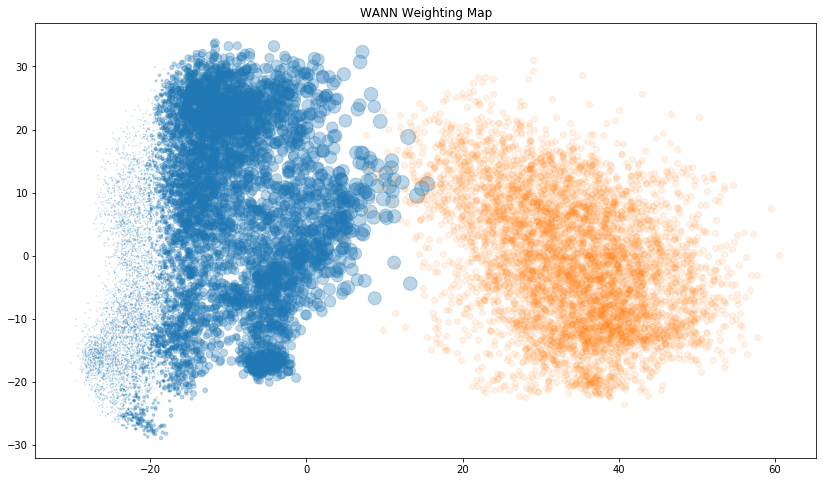

In [20]:
from sklearn.decomposition import PCA

plt.figure(figsize=(14, 8))

w = wann.get_weight(X[src_index]) / 10

xx = PCA(2).fit_transform(X)

plt.scatter(xx[src_index, 0 ], xx[src_index, 1], s=w, alpha=0.3, label="source")
plt.scatter(xx[tgt_index, 0 ], xx[tgt_index, 1], alpha=0.1, label="target")
plt.title("WANN Weighting Map")

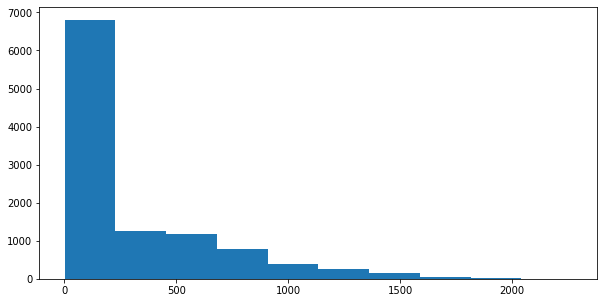

In [21]:
weights = wann.get_weight(X[src_index])

plt.figure(figsize=(10, 5))
plt.hist(weights, bins=10)
plt.show()